In [1]:
# System & I/O
import os
import numpy as np
import pandas as pd
from PIL import Image

# DeepFace
from deepface import DeepFace

# TensorFlow and Kera
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("BMI/BMI/Data/data.csv", index_col=0)

In [3]:
df.head(5)

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


In [4]:
df.shape

(4206, 4)

In [5]:
# We are manually splitting the dataset as we want to avoid the before and after images of the same person to be in both sets.
train_data = df[df['is_training']==1]
test_data = df[df['is_training']==0]

In [6]:
# Image augmentation -we are creating new images from existing ones to prevent overfitting
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    validation_split=0.2
)

In [7]:
# Loading the images and mapping them to BMI labels.
# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='BMI/BMI/Data/Images',
    x_col="name",
    y_col='bmi',
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw", # for regression tasks, returns float targets directly
    target_size=(224,224),
)
# Validation data generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='BMI/BMI/Data/Images',
    x_col="name",
    y_col='bmi',
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(224,224),
)

# Test data generator
test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = 'BMI/BMI/Data/Images',
    x_col = 'name',
    y_col = 'bmi',
    batch_size = 32,
    class_mode ='raw',
    target_size = (224,224)
    )

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 752 validated image filenames.


In [9]:
# ResNet50 model - Use transfer learning by leveraging learned filters from ImageNet.
from keras.applications import ResNet50V2

resnet_50_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all the layers
for layer in resnet_50_model.layers:
    layer.trainable = False

# Build model
model = Sequential([
    resnet_50_model,
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='linear'),
    Dropout(0.5),
    Dense(64, activation='linear'),
    Dense(1, activation='linear')
    ])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Callbacks
checkpoint_path = f"resnet_50_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=30,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

# Evaluation block
val_preds = model.predict(valid_generator)
val_true = valid_generator.labels
rmse = np.sqrt(mean_squared_error(val_true, val_preds))
val_mae = min(history.history['mae'])
val_loss = min(history.history['val_loss'])

print(f"Evaluation for resnet_50_model:")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAE:  {val_mae:.2f}")
print(f"   Loss: {val_loss:.2f}")

print(f"Finished training: resnet_50_model")

Epoch 1/30
81/81 [==============================] - 165s 2s/step - loss: 144.5693 - mae: 8.8852 - val_loss: 67.1852 - val_mae: 6.3755
Epoch 2/30
81/81 [==============================] - 164s 2s/step - loss: 77.3326 - mae: 6.8250 - val_loss: 63.6973 - val_mae: 6.3714
Epoch 3/30
81/81 [==============================] - 153s 2s/step - loss: 70.9481 - mae: 6.4945 - val_loss: 57.6912 - val_mae: 6.1004
Epoch 4/30
81/81 [==============================] - 142s 2s/step - loss: 68.1947 - mae: 6.4522 - val_loss: 56.8056 - val_mae: 5.7425
Epoch 5/30
81/81 [==============================] - 156s 2s/step - loss: 63.3907 - mae: 6.1765 - val_loss: 57.6000 - val_mae: 5.8901
Epoch 6/30
81/81 [==============================] - 134s 2s/step - loss: 62.6265 - mae: 6.0659 - val_loss: 56.8511 - val_mae: 5.7470
Epoch 7/30
81/81 [==============================] - 160s 2s/step - loss: 61.7598 - mae: 6.0515 - val_loss: 58.7570 - val_mae: 6.0625
Epoch 8/30
81/81 [==============================] - 161s 2s/step - l

In [11]:
# VGG16 model
from tensorflow.keras.applications import VGG16

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg16_model.layers:
    layer.trainable = False

# Build model
model = Sequential([
    vgg16_model,
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='linear'),
    Dropout(0.5),
    Dense(64, activation='linear'),
    Dense(1, activation='linear')
    ])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Callbacks
checkpoint_path = f"vgg16_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=30,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

# Evaluation block
val_preds = model.predict(valid_generator)
val_true = valid_generator.labels
rmse = np.sqrt(mean_squared_error(val_true, val_preds))
val_mae = min(history.history['mae'])
val_loss = min(history.history['val_loss'])

print(f"Evaluation for vgg16_model:")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAE:  {val_mae:.2f}")
print(f"   Loss: {val_loss:.2f}")

print(f"Finished training: vgg16_model")

Epoch 1/30
81/81 [==============================] - 343s 4s/step - loss: 185.2790 - mae: 10.0364 - val_loss: 59.0459 - val_mae: 6.1844
Epoch 2/30
81/81 [==============================] - 360s 4s/step - loss: 72.6407 - mae: 6.6336 - val_loss: 58.4586 - val_mae: 6.1108
Epoch 3/30
81/81 [==============================] - 379s 5s/step - loss: 71.7013 - mae: 6.5652 - val_loss: 58.5619 - val_mae: 6.2367
Epoch 4/30
81/81 [==============================] - 373s 5s/step - loss: 70.7789 - mae: 6.5297 - val_loss: 56.7547 - val_mae: 6.0911
Epoch 5/30
81/81 [==============================] - 351s 4s/step - loss: 70.1985 - mae: 6.5613 - val_loss: 56.6898 - val_mae: 5.9459
Epoch 6/30
81/81 [==============================] - 355s 4s/step - loss: 69.0410 - mae: 6.4678 - val_loss: 57.0327 - val_mae: 6.1519
Epoch 7/30
81/81 [==============================] - 362s 4s/step - loss: 68.0279 - mae: 6.3872 - val_loss: 56.2053 - val_mae: 5.8882
Epoch 8/30
81/81 [==============================] - 378s 5s/step - 

In [15]:
# VGGFace - Deepface model

from deepface import DeepFace
from tensorflow.keras.models import Model

# Load and unwrap VGG-Face
vggface_client = DeepFace.build_model("VGG-Face")
vggface_full = vggface_client.model  

# Extract up to the final layer: 'flatten_3'
vggface_model = Model(inputs=vggface_full.input, outputs=vggface_full.get_layer("flatten_3").output)


# Freeze all the layers
for layer in vggface_model.layers:
    layer.trainable = False

# Build model
model = Sequential([
    vggface_model,
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='linear'),
    Dropout(0.5),
    Dense(64, activation='linear'),
    Dense(1, activation='linear')
    ])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Callbacks
checkpoint_path = f"vggface_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=30,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

# Evaluation block
val_preds = model.predict(valid_generator)
val_true = valid_generator.labels
rmse = np.sqrt(mean_squared_error(val_true, val_preds))
val_mae = min(history.history['mae'])
val_loss = min(history.history['val_loss'])

print(f"Evaluation for vggface_model:")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAE:  {val_mae:.2f}")
print(f"   Loss: {val_loss:.2f}")

print(f"Finished training: vggface_model")

Epoch 1/30
81/81 [==============================] - 354s 4s/step - loss: 677.3561 - mae: 23.1163 - val_loss: 185.6277 - val_mae: 11.0261
Epoch 2/30
81/81 [==============================] - 357s 4s/step - loss: 186.2092 - mae: 10.8284 - val_loss: 148.8963 - val_mae: 9.7039
Epoch 3/30
81/81 [==============================] - 382s 5s/step - loss: 128.5268 - mae: 8.9524 - val_loss: 106.8084 - val_mae: 8.0898
Epoch 4/30
81/81 [==============================] - 417s 5s/step - loss: 89.1549 - mae: 7.2723 - val_loss: 66.2904 - val_mae: 6.2602
Epoch 5/30
81/81 [==============================] - 379s 5s/step - loss: 60.6836 - mae: 5.7883 - val_loss: 48.7753 - val_mae: 5.1837
Epoch 6/30
81/81 [==============================] - 388s 5s/step - loss: 47.2302 - mae: 5.1511 - val_loss: 41.4380 - val_mae: 4.9619
Epoch 7/30
81/81 [==============================] - 383s 5s/step - loss: 45.0207 - mae: 5.0427 - val_loss: 40.8613 - val_mae: 4.9465
Epoch 8/30
81/81 [==============================] - 393s 5s/

Found 752 validated image filenames.
24/24 [==============================] - 104s 4s/step

 Test Evaluation:
   RMSE: 7.57
   MAE:  5.63


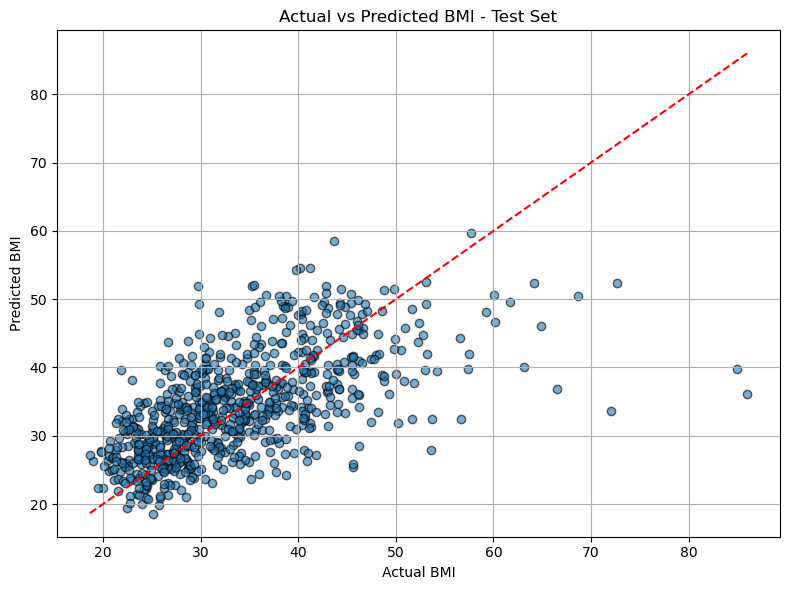

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load best model
model_path = "vggface_model.h5"
model = load_model(model_path)

# Recreate test_generator
csv_path = r"C:\Users\kadavelli\Downloads\BMI\BMI\Data\data.csv"
image_dir = r"C:\Users\kadavelli\Downloads\BMI\BMI\Data\Images"
df = pd.read_csv(csv_path)
test_data = df[df['is_training'] == 0]

datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=image_dir,
    x_col="name",
    y_col="bmi",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False
)

# Predict on test set
test_preds = model.predict(test_generator).flatten()
test_true = test_generator.labels

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
test_mae = mean_absolute_error(test_true, test_preds)

print(f"\n Test Evaluation:")
print(f"   RMSE: {test_rmse:.2f}")
print(f"   MAE:  {test_mae:.2f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_true, test_preds, alpha=0.6, edgecolor='k')
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'r--')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Actual vs Predicted BMI - Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()


I selected the **VGG-Face** model for deployment as it gave the best overall performance on the test set (RMSE: 7.57, MAE: 5.63).  


This model was saved and successfully deployed using a Flask app with both webcam and image upload support.
